In [122]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns

In [123]:
# we don't use keras for modelling. just for image augmentation
from keras.preprocessing.image import ImageDataGenerator

In [124]:
proj_root = os.path.abspath(os.path.join('../')) 
datadir = os.path.join(proj_root, 'data/labels/')
arcdir = os.path.join(proj_root, 'models/archive/')
modeldir = os.path.join(proj_root, 'models/')

if not os.path.isdir(arcdir): os.path.makedirs(arcdir)
if not os.path.isdir(modeldir): os.path.makedirs(modeldir)

# Load Data

In [125]:
X1 = np.load(os.path.join(datadir, 'X-1.npy'))
Y1 = np.load(os.path.join(datadir, 'Y-1.npy'))

X2 = np.load(os.path.join(datadir, 'X-2.npy'))
Y2 = np.load(os.path.join(datadir, 'Y-2.npy'))


X = np.vstack((X1, X2))
Y = np.concatenate((Y1, Y2))

X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.5, stratify=Y, random_state=87)

pd.concat([pd.Series(Y_train).value_counts(),
           pd.Series(Y_test).value_counts()], axis=1)

,0,1
b'0',8,8
b'1',51,50
b'2',16,15
b'3',11,10
b'4',10,10
b'5',10,11
b'6',11,10
b'7',10,10
b'8',11,11
b'9',11,12


In [126]:
# Define preprocessor class for pipelining
class MyTrans:
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)
    def get_params(self, deep=True):
        return {}

# quick test
a = X[0].flatten()
trans = MyTrans()
trans.fit(X)
b = trans.transform(X)[0]
np.all(a==b)

True

# Fit Gaussian Naive Bayes

In [127]:
# Fit Gaussian Naive Bayes
pipe = Pipeline([
    ('flatten data to "obs*feature" shape', MyTrans()), 
    ('fit to gaussian naive bayes', GaussianNB())
])
fit = pipe.fit(X_train, Y_train)

print('train performance', fit.score(X_train, Y_train))
print('test performance', fit.score(X_test, Y_test))

train performance 1.0
test performance 1.0


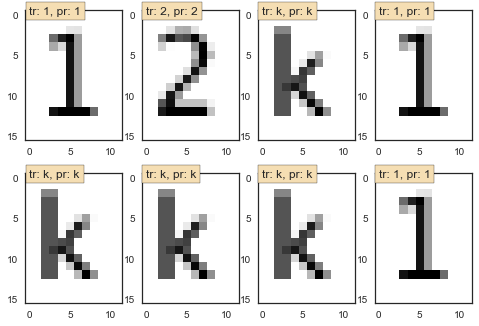

In [128]:
# observe prediction or random cases
def random_plot(X, y, predicted):
    sns.set_style('white')
    indices = np.random.choice(len(y), min(8, len(y)))
    count = 0
    for i in indices:
        count += 1
        ax = plt.subplot(2, 4, count)
        ax.imshow(X[i], cmap='gray')
        ax.text(0, 0, 
                'tr: %s, pr: %s' % (y[i].decode('utf-8'), predicted[i].decode('utf-8')), \
                bbox={'facecolor':"wheat"})
    plt.show(block=False)

pred = fit.predict(X_test)
random_plot(X_test, Y_test, pred)


In [129]:
# Check the robustness to small variation
def generate_augmented_data(X, Y, target_size, seed=87):
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                                 data_format='channels_last', channel_shift_range=0.5)
    out_X = None
    out_Y = None
    for x,y in datagen.flow(np.expand_dims(X, axis=4), Y, seed=seed):
        if out_X is None:
            out_X = x
            out_Y = y
        else:
            out_X = np.vstack([out_X, x])
            out_Y = np.concatenate([out_Y, y])
        if len(out_Y) >= target_size: 
            break
    out_X = out_X.squeeze()
    return out_X, out_Y

X_generated, Y_generated = generate_augmented_data(X_test, Y_test, 500)

             precision    recall  f1-score   support

       b'0'       0.67      0.50      0.57        16
       b'1'       0.87      0.59      0.70       100
       b'2'       0.79      0.37      0.50        30
       b'3'       0.11      0.25      0.16        20
       b'4'       0.38      0.50      0.43        20
       b'5'       0.91      0.45      0.61        22
       b'6'       0.38      0.25      0.30        20
       b'7'       0.34      0.75      0.47        20
       b'8'       0.17      0.27      0.21        22
       b'9'       0.56      0.38      0.45        24
       b'd'       0.36      0.50      0.42        26
       b'k'       0.86      0.87      0.87       182

avg / total       0.70      0.62      0.64       502



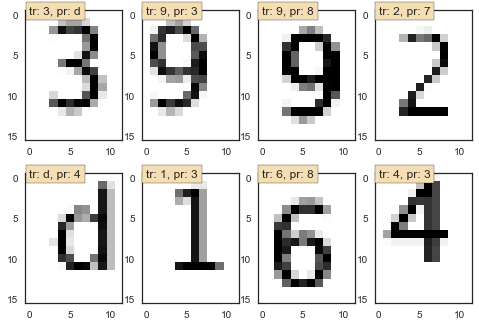

In [130]:
predicted = fit.predict(X_generated) 
print(classification_report(Y_generated, predicted))
#print(confusion_matrix(Y_generated, prdicted))
wrong = (Y_generated != predicted)
random_plot(X_generated[wrong], Y_generated[wrong], predicted[wrong])

In [131]:
# train the model with augmented data set
X_train_gen, Y_train_gen = generate_augmented_data(X_train, Y_train, 10000)
fit_nb = pipe.fit(X_train_gen, Y_train_gen)

X_test_gen, Y_test_gen = generate_augmented_data(X_test, Y_test, 10000)

pred = fit_nb.predict(X_test_gen)

In [132]:
# performance on the original test data
fit_nb.score(X_test, Y_test)

1.0

In [133]:
pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

col_0,b'0',b'1',b'2',b'3',b'4',b'5',b'6',b'7',b'8',b'9',b'd',b'k',All
row_0,,,,,,,,,,,,,
b'0',156,0,0,0,2,1,109,0,3,16,32,0,319
b'1',0,1687,11,63,0,9,0,9,201,1,0,13,1994
b'2',0,37,494,0,6,0,2,24,34,0,2,0,599
b'3',2,48,20,188,3,69,0,12,56,0,0,0,398
b'4',0,2,3,0,333,2,0,0,24,3,33,0,400
b'5',0,1,0,0,0,350,0,4,66,17,0,2,440
b'6',6,0,0,0,0,2,287,0,83,5,16,1,400
b'7',8,0,55,0,0,0,0,305,25,3,2,2,400
b'8',3,2,0,0,14,45,91,0,265,3,2,14,439


In [134]:
print(classification_report(Y_test_gen, pred))

             precision    recall  f1-score   support

       b'0'       0.77      0.49      0.60       319
       b'1'       0.89      0.85      0.87      1994
       b'2'       0.84      0.82      0.83       599
       b'3'       0.75      0.47      0.58       398
       b'4'       0.84      0.83      0.84       400
       b'5'       0.64      0.80      0.71       440
       b'6'       0.52      0.72      0.60       400
       b'7'       0.84      0.76      0.80       400
       b'8'       0.24      0.60      0.35       439
       b'9'       0.89      0.84      0.87       479
       b'd'       0.80      0.72      0.76       519
       b'k'       0.99      0.88      0.93      3626

avg / total       0.85      0.80      0.82     10013



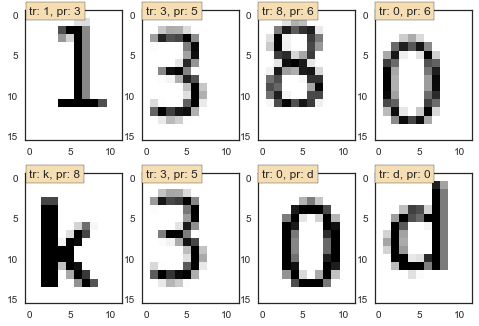

In [135]:
wrong = (Y_test_gen != pred)
random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])

In [136]:
# Try more complex model with polynomial terms
#pipe2 = Pipeline([
#    ('flatten data to "obs*feature" shape', MyTrans()), 
#    ('Make polynomial features', PolynomialFeatures(degree=2, interaction_only=True)),
#    ('fit to gaussian naive bayes', GaussianNB())
#])
#fit_nb2 = pipe2.fit(X_train_gen, Y_train_gen)

In [137]:
#pred = fit_nb2.predict(X_test_gen)

In [138]:
#pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

In [139]:
#print(classification_report(Y_test_gen, pred))

In [140]:
#wrong = (Y_test_gen != pred)
#random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])

In [141]:
# performance on the original test data
#fit_nb2.score(X_test, Y_test)

**Summary of Naive Bayes**

- 100% accuracy on original data
- Not robust to image augmentation. Accuracy becomes 70%
- Trained on augmented data, accuracy reaches 85% (still 100% accurate for original data)
- Polynomial features does not seem to help (reduces to 83%)

# Fit Multilayer Perceptron

In [142]:
pipe = Pipeline([
    ('flatten data to "obs*feature" shape', MyTrans()), 
    ('fit to multilayer perceptron', \
     MLPClassifier((100,), alpha=1, max_iter=1000))
])
fit = pipe.fit(X_train, Y_train)
print(fit.score(X_train, Y_train))
print(fit.score(X_test, Y_test))
print(fit.score(X_test_gen, Y_test_gen))

1.0
1.0
0.660341555977


In [143]:
fit_mlp = pipe.fit(X_train_gen, Y_train_gen)

In [144]:
print(fit_mlp.score(X_test, Y_test))
print(fit_mlp.score(X_train_gen, Y_train_gen))
print(fit_mlp.score(X_test_gen, Y_test_gen))
pred = fit_mlp.predict(X_test_gen)

1.0
0.991511035654
0.987815839409


In [145]:
print(classification_report(Y_test_gen, pred))
pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

             precision    recall  f1-score   support

       b'0'       0.98      0.97      0.98       319
       b'1'       1.00      1.00      1.00      1994
       b'2'       0.99      0.97      0.98       599
       b'3'       0.99      0.97      0.98       398
       b'4'       0.98      0.96      0.97       400
       b'5'       1.00      0.99      1.00       440
       b'6'       0.96      0.94      0.95       400
       b'7'       0.93      0.98      0.96       400
       b'8'       0.98      0.96      0.97       439
       b'9'       0.98      0.97      0.98       479
       b'd'       0.97      0.99      0.98       519
       b'k'       1.00      1.00      1.00      3626

avg / total       0.99      0.99      0.99     10013



col_0,b'0',b'1',b'2',b'3',b'4',b'5',b'6',b'7',b'8',b'9',b'd',b'k',All
row_0,,,,,,,,,,,,,
b'0',311,0,0,0,0,0,3,1,0,0,4,0,319
b'1',0,1994,0,0,0,0,0,0,0,0,0,0,1994
b'2',0,0,581,0,0,0,0,18,0,0,0,0,599
b'3',0,6,0,385,3,0,0,4,0,0,0,0,398
b'4',0,0,2,0,385,0,0,0,0,2,11,0,400
b'5',0,0,0,0,0,436,0,0,0,0,0,4,440
b'6',4,0,0,0,0,0,378,0,9,7,0,2,400
b'7',0,0,2,2,0,0,0,394,1,1,0,0,400
b'8',0,0,0,0,0,0,5,6,421,0,0,7,439


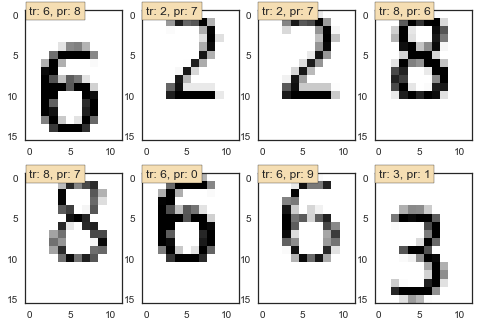

In [146]:
wrong = (Y_test_gen != pred)
if np.any(wrong):
    random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])

MLP turns out to be very powerful with 99% accuracy for
augmented data.  
Now let's look for various parameter combination by grid search to improve the model further more.

In [147]:
pipe = Pipeline([
    ('flatten data to "obs*feature" shape', MyTrans()), 
    ('MLP', MLPClassifier(max_iter=1000))
])
alpha_options = [1e-5, 1e-3, 0.01]
layer_options = [(100,), (100,100), (100,100,100)]
param_grid = dict(
    MLP__alpha=alpha_options,
    MLP__hidden_layer_sizes=layer_options
)

grid_savename = os.path.join(arcdir, 'label_mlp_grid.pkl')
if False:  # change to True to do grid search again
    grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=2, verbose=5)
    grid.fit(X_train_gen, Y_train_gen)
    
    joblib.dump(grid, grid_savename)
else:
    grid = joblib.load(grid_savename)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] MLP__alpha=1e-05, MLP__hidden_layer_sizes=(100,) ................
[CV] MLP__alpha=1e-05, MLP__hidden_layer_sizes=(100,) ................
[CV]  MLP__alpha=1e-05, MLP__hidden_layer_sizes=(100,), score=0.998504, total=  15.7s
[CV] MLP__alpha=1e-05, MLP__hidden_layer_sizes=(100,) ................
[CV]  MLP__alpha=1e-05, MLP__hidden_layer_sizes=(100,), score=0.999501, total=  17.7s
[CV] MLP__alpha=1e-05, MLP__hidden_layer_sizes=(100,) ................
[CV]  MLP__alpha=1e-05, MLP__hidden_layer_sizes=(100,), score=1.000000, total=  15.5s
[CV] MLP__alpha=1e-05, MLP__hidden_layer_sizes=(100,) ................
[CV]  MLP__alpha=1e-05, MLP__hidden_layer_sizes=(100,), score=0.997500, total=  17.8s
[CV] MLP__alpha=1e-05, MLP__hidden_layer_sizes=(100, 100) ............
[CV]  MLP__alpha=1e-05, MLP__hidden_layer_sizes=(100,), score=0.999499, total=  16.9s
[CV] MLP__alpha=1e-05, MLP__hidden_layer_sizes=(100, 100) ............
[CV]  MLP__al

[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.8min


[CV]  MLP__alpha=1e-05, MLP__hidden_layer_sizes=(100, 100, 100), score=0.999499, total=  15.7s
[CV] MLP__alpha=0.001, MLP__hidden_layer_sizes=(100,) ................
[CV]  MLP__alpha=0.001, MLP__hidden_layer_sizes=(100,), score=0.999501, total=  18.9s
[CV] MLP__alpha=0.001, MLP__hidden_layer_sizes=(100,) ................
[CV]  MLP__alpha=0.001, MLP__hidden_layer_sizes=(100,), score=0.998504, total=  18.8s
[CV] MLP__alpha=0.001, MLP__hidden_layer_sizes=(100,) ................
[CV]  MLP__alpha=0.001, MLP__hidden_layer_sizes=(100,), score=1.000000, total=  20.5s
[CV] MLP__alpha=0.001, MLP__hidden_layer_sizes=(100,) ................
[CV]  MLP__alpha=0.001, MLP__hidden_layer_sizes=(100,), score=0.997000, total=  18.9s
[CV] MLP__alpha=0.001, MLP__hidden_layer_sizes=(100, 100) ............
[CV]  MLP__alpha=0.001, MLP__hidden_layer_sizes=(100,), score=1.000000, total=  18.6s
[CV] MLP__alpha=0.001, MLP__hidden_layer_sizes=(100, 100) ............
[CV]  MLP__alpha=0.001, MLP__hidden_layer_sizes=(

[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:  6.3min finished


In [148]:
odr = np.argsort(grid.cv_results_['mean_test_score'])
for i in reversed(odr):
    print("%0.4f (+/-%0.04f) for %r" % 
          (grid.cv_results_['mean_test_score'][i], 
           grid.cv_results_['std_test_score'][i] * 2, 
           grid.cv_results_['params'][i]))
print(grid.best_params_)

0.9992 (+/-0.0016) for {'MLP__hidden_layer_sizes': (100, 100), 'MLP__alpha': 1e-05}
0.9991 (+/-0.0021) for {'MLP__hidden_layer_sizes': (100, 100, 100), 'MLP__alpha': 0.001}
0.9990 (+/-0.0028) for {'MLP__hidden_layer_sizes': (100, 100), 'MLP__alpha': 0.01}
0.9990 (+/-0.0018) for {'MLP__hidden_layer_sizes': (100,), 'MLP__alpha': 0.01}
0.9990 (+/-0.0023) for {'MLP__hidden_layer_sizes': (100,), 'MLP__alpha': 0.001}
0.9990 (+/-0.0018) for {'MLP__hidden_layer_sizes': (100, 100, 100), 'MLP__alpha': 1e-05}
0.9990 (+/-0.0018) for {'MLP__hidden_layer_sizes': (100,), 'MLP__alpha': 1e-05}
0.9988 (+/-0.0016) for {'MLP__hidden_layer_sizes': (100, 100, 100), 'MLP__alpha': 0.01}
0.9987 (+/-0.0021) for {'MLP__hidden_layer_sizes': (100, 100), 'MLP__alpha': 0.001}
{'MLP__hidden_layer_sizes': (100, 100), 'MLP__alpha': 1e-05}


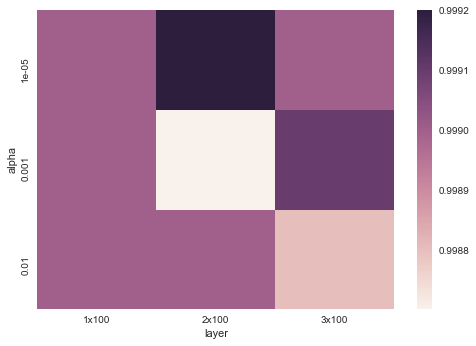

layer,1x100,2x100,3x100
alpha,,,
0.00001,0.999001,0.999201,0.999001
0.00100,0.999001,0.998702,0.999101
0.01000,0.999001,0.999001,0.998802


In [149]:
avg = grid.cv_results_['mean_test_score']
alpha = [p['MLP__alpha'] for p in grid.cv_results_['params']]
layer = [p['MLP__hidden_layer_sizes'] for p in grid.cv_results_['params']]
layer = ['%dx%3d' % (len(l), l[0]) for l in layer]
df = pd.DataFrame(dict(accuracy=avg, alpha=alpha, layer=layer))
df_wide = df.pivot('alpha', 'layer', 'accuracy')
sns.heatmap(df_wide)
plt.show()
df_wide

In [150]:
pred = grid.predict(X_test_gen)
print(classification_report(Y_test_gen, pred))
pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

             precision    recall  f1-score   support

       b'0'       1.00      1.00      1.00       319
       b'1'       1.00      1.00      1.00      1994
       b'2'       1.00      1.00      1.00       599
       b'3'       1.00      1.00      1.00       398
       b'4'       1.00      1.00      1.00       400
       b'5'       1.00      1.00      1.00       440
       b'6'       1.00      1.00      1.00       400
       b'7'       1.00      1.00      1.00       400
       b'8'       1.00      1.00      1.00       439
       b'9'       1.00      1.00      1.00       479
       b'd'       1.00      1.00      1.00       519
       b'k'       1.00      1.00      1.00      3626

avg / total       1.00      1.00      1.00     10013



col_0,b'0',b'1',b'2',b'3',b'4',b'5',b'6',b'7',b'8',b'9',b'd',b'k',All
row_0,,,,,,,,,,,,,
b'0',319,0,0,0,0,0,0,0,0,0,0,0,319
b'1',0,1994,0,0,0,0,0,0,0,0,0,0,1994
b'2',0,0,599,0,0,0,0,0,0,0,0,0,599
b'3',0,0,0,398,0,0,0,0,0,0,0,0,398
b'4',0,0,0,0,400,0,0,0,0,0,0,0,400
b'5',0,0,0,0,0,440,0,0,0,0,0,0,440
b'6',0,0,0,0,0,0,400,0,0,0,0,0,400
b'7',0,0,0,0,0,0,0,400,0,0,0,0,400
b'8',0,0,0,0,0,0,0,1,438,0,0,0,439


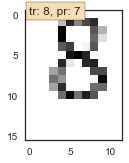

In [151]:
wrong = (Y_test_gen != pred)
if np.any(wrong):
    random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])

In [152]:
print(grid.score(X_test_gen, Y_test_gen))
print(grid.score(X_test, Y_test))

0.999900129831
1.0


The best model predicts 99.99% accurate for generated test data (100% for original test data).
But I prefer the second best for no reason (maybe I like three).

In [162]:
pipe = Pipeline([
    ('flatten data to "obs*feature" shape', MyTrans()), 
    ('MLP', MLPClassifier((100,100,100), alpha=0.001, max_iter=1000))
])
fit_mlp = pipe.fit(X_train_gen, Y_train_gen)

0.999800259662
1.0


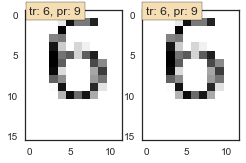

             precision    recall  f1-score   support

       b'0'       1.00      1.00      1.00       319
       b'1'       1.00      1.00      1.00      1994
       b'2'       1.00      1.00      1.00       599
       b'3'       1.00      1.00      1.00       398
       b'4'       1.00      1.00      1.00       400
       b'5'       1.00      1.00      1.00       440
       b'6'       1.00      0.99      1.00       400
       b'7'       1.00      1.00      1.00       400
       b'8'       1.00      1.00      1.00       439
       b'9'       1.00      1.00      1.00       479
       b'd'       1.00      1.00      1.00       519
       b'k'       1.00      1.00      1.00      3626

avg / total       1.00      1.00      1.00     10013



col_0,b'0',b'1',b'2',b'3',b'4',b'5',b'6',b'7',b'8',b'9',b'd',b'k',All
row_0,,,,,,,,,,,,,
b'0',319,0,0,0,0,0,0,0,0,0,0,0,319
b'1',0,1994,0,0,0,0,0,0,0,0,0,0,1994
b'2',0,0,599,0,0,0,0,0,0,0,0,0,599
b'3',0,0,0,398,0,0,0,0,0,0,0,0,398
b'4',0,0,0,0,400,0,0,0,0,0,0,0,400
b'5',0,0,0,0,0,440,0,0,0,0,0,0,440
b'6',0,0,0,0,0,0,398,0,0,2,0,0,400
b'7',0,0,0,0,0,0,0,400,0,0,0,0,400
b'8',0,0,0,0,0,0,0,0,439,0,0,0,439


In [163]:
print(fit_mlp.score(X_test_gen, Y_test_gen))
print(fit_mlp.score(X_test, Y_test))
pred = fit_mlp.predict(X_test_gen)
wrong = (Y_test_gen != pred)
if np.any(wrong):
    random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])
print(classification_report(Y_test_gen, pred))
pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

In [165]:
model_savename = os.path.join(modeldir, 'label_mlp.pkl')
joblib.dump(fit_mlp, model_savename)

['/home/kota/Documents/kgschart/models/label_mlp.pkl']